# Анализ частот в тексте

## Код

### Библиотеки и технические классы

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!pip install wordcloud

import matplotlib.pyplot as plt
import matplotlib as mpl

import re #регулярки для проверки на латиницу
import string
import numpy as np
import itertools
from operator import itemgetter
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
punctuation =string.punctuation +'–'
#короткое тире - часть слова
re_punctuation = '!"#$%&\'()*+,./:;<=>?@~–^_`{|}—»«'
numbers = '0123456789'

In [4]:
class LanguageException(BaseException):
    def __init__(self, problem = ''):
        self.problem = problem
    def __str__(self):
        return str(self.problem)

In [5]:
class Language:
    def __init__(self, *args):
        self.universal = 'universal'
        self.russian = 'russian'
        self.english = 'english'
        self.сyrillic = 'russian'
        self.latin = 'english'
        self.other = args
        
language = Language()

In [6]:
class meaningless_words:
    def __init__(self, russian_stopwords = stopwords.words('russian'), english_stopwords = stopwords.words('english')):
        self.universal = set(russian_stopwords) | set(english_stopwords )
        self.russian = set(russian_stopwords)
        self.english = set(english_stopwords)

### Предлоги, союзы и прочие часто встречающиеся слова  

In [7]:
my_meaningless_words = meaningless_words()

### Основной класс Text_information

In [8]:
def get_the_words(text):
    only_words = re.sub('[' +re_punctuation + '\n' + numbers +']|\s-+|-+\s|\[|\]', ' ', text.lower())
    #only_words = re.sub('[' +re_punctuation + '\n' + numbers +']', ' ', text.lower())
    #only_words = re.sub('\s-+\s', ' ', only_words)
    return only_words


def get_punctuation_marks(text):
    marks = re.findall('[' + re_punctuation + ']', text)
    return ''.join(marks)

def separate_languages(words):
    rus = re.compile('^[а-яА-ЯёЁ]+')
    eng = re.compile('^[a-zA-Z]+')
    
    сyrillic = list(filter(rus.match, words))
    latin = list(filter(eng.match, words))
    return сyrillic, latin

#число восклицательных и вопросительных знаков
def calculate_emphasis(text):
    еxclamation_points = re.findall('[!]', text)
    question_marks = re.findall('[?]', text)
    return (len(еxclamation_points), len(question_marks))

In [9]:
class Text_information:
    def __init__(self, text=''):
        self.text = text
        self.words = word_tokenize(get_the_words(text))
        self.marks = word_tokenize(get_punctuation_marks(text))
        сyrillic, latin = separate_languages(self.words)
        self.is_сyrillic = bool(сyrillic)
        self.сyrillic = сyrillic
        self.is_latin = bool(latin)
        self.latin = latin       
        self.emphasis = calculate_emphasis(text)
        self.marks_statistics = FreqDist(self.marks)
    
    def word_statistics(self,meaningful = False,language = 'universal'): 
        if not meaningful:
            if language == 'universal':
                return FreqDist(self.words)
            if language == 'russian':
                if not self.is_сyrillic:
                    raise LanguageException('No сyrillic words in the text')
                return FreqDist(self.сyrillic)
            if language == 'english':
                if not self.is_latin:
                    raise LanguageException('No latin words in the text')
                return FreqDist(self.latin)
            raise LanguageException('Language is not supported')
        
        return FreqDist(self.only_meaningful_words( language))
        
    def plot_word_statistic(self, number = 1, meaningful = False, language = 'universal'):
        self.word_statistics(meaningful, language).plot(number)
        

        
    def deviation_from_Zipf(self, meaningful = False, language = 'universal'):
        frequencies = sorted(list(self.word_statistics(meaningful,language).values()), reverse = True)
        frequencies = np.array(frequencies)
        hypothesis = 1 / (np.arange(frequencies.size)+1) * frequencies[0]
        #print(frequencies)
        return np.std(frequencies - hypothesis)
        
    def plot_with_Zipf(self, meaningful = False, language = 'universal'):

        frequencies = sorted(list(self.word_statistics(meaningful, language).values()), reverse = True)

        hypothesis = 1 / (np.arange(len(frequencies))+1) * frequencies[0]
        print('hypothesis:' ,hypothesis)
        
        fig, ax = plt.subplots()
        plt.plot(range(1,len(frequencies)+1), frequencies)
        plt.plot(range(1, len(frequencies)+1), hypothesis)
        ax.set_xlabel('log порядкового номера слова')
        ax.set_ylabel('log частоты')
        plt.xscale('log')
        plt.yscale('log')
        plt.plot()
        
    def only_meaningful_words(self, language = 'universal'):
            
        if language == 'universal':
            return [x for x in self.words if x not in my_meaningless_words.universal]
        elif language == 'russian':
            if not self.is_сyrillic:
                raise LanguageException('No сyrillic words in the text')
            return [x for x in self.сyrillic if x not in my_meaningless_words.russian]
        elif language == 'english':
            if not self.is_latin:
                raise LanguageException('No latin words in the text')
            return [x for x in self.latin if x not in my_meaningless_words.english]
        else: 
            raise LanguageException('Language is not supported')    
            
         
  
    def words_occurring_n_times(self, meaningful = False,language = 'universal'):
        Dict = self.word_statistics(meaningful,language)
        New_Dict = {}
        for value, items in itertools.groupby(sorted(Dict.items(), key=itemgetter(1)), key=itemgetter(1)):
            New_Dict[value] = set(map(itemgetter(0), items))
        return New_Dict

    def plot_the_number_of_words_by_occurrence(self, meaningful = False,language = 'universal', logarithmic = False):
        Dict = self.words_occurring_n_times(meaningful,language)
        frequencies = []
        quantities = []
        
        for x in sorted(Dict.keys()):
            frequencies.append(x)
            quantities.append(len(Dict[x]))
        
        #print(quantities)
        fig, ax = plt.subplots()
        plt.plot(frequencies, quantities)
        ax.set_xlabel('частота встречаемости слова')
        ax.set_ylabel('количество слов данной частоты')
        if logarithmic:
            plt.xscale('log')
            plt.yscale('log')
        plt.plot()


    def some_statistic(self, meaningful = False, language = 'universal'):
        Dict = self.word_statistics(meaningful, language)
        frequencies = list(Dict.values())

        frequencies = np.array(frequencies)
        F = {}
        F['most_frequent'] = frequencies.max()
        F['least_frequent'] = frequencies.min()
        F['number_of_words'] = frequencies.sum()
        F['number_of_different_words'] = frequencies.size
        F['mean'] = np.mean(frequencies)
        F['dispersion'] = np.std(frequencies)
        F['median'] = np.median(frequencies)
        F['number_of_unique_words'] = np.count_nonzero(frequencies == 1)
        return F
    
    def percent_of_most_common_words(self,k = 20, meaningful = False, language = 'universal' ):
        if k > 100 or k < 0:
            raise LanguageException('it\'s not a percentage')

        frequencies = sorted(list(self.word_statistics(meaningful,language).values()), reverse = True)
          
        s = 0
        for e in range(int(len(frequencies) * k / 100)):
            s = s+ frequencies[e]
        return (s / sum(frequencies)) * 100
    
    def percent_of_unique_words(self, meaningful = False, language = 'universal'):
        D = self.some_statistic(meaningful, language)
        return D['number_of_unique_words']/D['number_of_words'] *100
    
    def percent_of_meaningful_words(self, language = 'universal'):
        return (self.some_statistic(meaningful = True, language=language)['number_of_words'] / 
    self.some_statistic(meaningful = False, language=language)['number_of_words'] *100)
    
    def phrases(self, length = 2, language = 'universal'):
        if length == 1:
            return self.words
        
        if language == 'universal':
            prewords = self.words
        elif language == 'russian':
            if not self.is_сyrillic:
                raise LanguageException('No сyrillic words in the text')
            prewords = self.сyrillic
        elif language == 'english':
            if not self.is_latin:
                raise LanguageException('No latin words in the text')
            prewords = self.latin
        else: 
            raise LanguageException('Language is not supported') 
        
        word_groups = list(zip(*(prewords[i:-1] for i in range(length))))
        return word_groups
    
    def phrases_statistics(self, length = 2, language = 'universal'):
        if length==1:
            return self.word_statistics(False, language)
        return(FreqDist(self.phrases(length, language)))
    
    def plot_phrases_with_Zipf(self,length = 2, language = 'universal'):
        if length ==1:
            self.plot_with_Zipf(False, language)
        else:
            frequencies = sorted(list(self.phrases_statistics(length,language).values()), reverse = True)
            hypothesis = 1 / (np.arange(len(frequencies))+1) * frequencies[0]
            fig, ax = plt.subplots()
            plt.plot(range(1,len(frequencies)+1), frequencies)
            plt.plot(range(1, len(frequencies)+1), hypothesis)
            ax.set_xlabel('log порядкового номера слова')
            ax.set_ylabel('log частоты')
            plt.xscale('log')
            plt.yscale('log')
            plt.plot()

            
    def some_phrases_statistic(self, length = 2, language = 'universal'):
        if length ==1:
            return self.some_statistic(False, language) 
        Dict = self.phrases_statistics(length, language)
        frequencies = list(Dict.values())
        frequencies = np.array(frequencies)
        F = {}
        F['most_frequent'] = frequencies.max()
        F['least_frequent'] = frequencies.min()
        F['number_of_words'] = frequencies.sum()
        F['number_of_different_words'] = frequencies.size
        F['mean'] = np.mean(frequencies)
        F['dispersion'] = np.std(frequencies)
        F['median'] = np.median(frequencies)
        F['number_of_unique_words'] = np.count_nonzero(frequencies == 1)
        return F
    
    def plot_phrases_statistic(self,number = 1,length = 2, language = 'universal'):
        if length ==1:
             self.plot_word_statistic(number, False, language)
        else:
            self.phrases_statistics(length, language).plot(number)
    
    def phrases_occurring_n_times(self,length = 2, language = 'universal'):
        if length ==1:
            return self.words_occurring_n_times( meaningful = False,language=language)
        Dict = self.phrases_statistics(length,language)
        New_Dict = {}
        for value, items in itertools.groupby(sorted(Dict.items(), key=itemgetter(1)), key=itemgetter(1)):
            New_Dict[value] = set(map(itemgetter(0), items))
        return New_Dict    
    
    
    def plot_the_number_of_phrases_by_occurrence(self, length = 2, language = 'universal', logarithmic = False):
        if length ==1:
            self.plot_the_number_of_words_by_occurrence(meaningful = False, language=language, logarithmic=logarithmic)
        else:
            Dict = self.phrases_occurring_n_times(length,language)
            frequencies = []
            quantities = []
        
            for x in sorted(Dict.keys()):
                frequencies.append(x)
                quantities.append(len(Dict[x]))
        
            #print(quantities)
            fig, ax = plt.subplots()
            plt.plot(frequencies, quantities)
            ax.set_xlabel('частота встречаемости слова')
            ax.set_ylabel('количество слов данной частоты')
            if logarithmic:
                plt.xscale('log')
                plt.yscale('log')
            plt.plot()
            
            
    def cloud(self,  meaningful = False,language = 'universal' ):
        if not meaningful:
            if language == 'universal':
                wcloud = WordCloud().generate(' '.join(self.words))
            elif language == 'russian':
                if not self.is_сyrillic:
                    raise LanguageException('No сyrillic words in the text')
                wcloud = WordCloud().generate(' '.join(self.сyrillic))
            elif language == 'english':
                if not self.is_latin:
                    raise LanguageException('No latin words in the text')
                wcloud = WordCloud().generate(' '.join(self.latin))
            else: 
                raise LanguageException('Language is not supported') 
                
            
        else:
            wcloud = WordCloud().generate(' '.join(self.only_meaningful_words(language)))
            
        plt.imshow(wcloud  , interpolation='bilinear')
        plt.axis('off')
        plt.show()

## Книги

In [10]:
f = open('Text1.txt', 'r', encoding = 'utf-8')
text = f.read()
f.close()

The_Master_and_Margarita = Text_information(text)

f = open('Text2.txt', 'r', encoding = 'utf-8')
text = f.read()
f.close()

Eugene_Onegin = Text_information(text)

f = open('Text3.txt', 'r', encoding = 'utf-8')
text = f.read()
f.close()

War_and_Peace_12 = Text_information(text)

f = open('Text4.txt', 'r', encoding = 'utf-8')
text = f.read()
f.close()

Dead_Souls_1 = Text_information(text)

f = open('Text5.txt', 'r', encoding = 'utf-8')
text = f.read()
f.close()

Who_is_Happy_in_Russia = Text_information(text)

f = open('Text6.txt', 'r', encoding = 'utf-8')
text = f.read()
f.close()

Mtsyri = Text_information(text)


Books = [(War_and_Peace_12,'War_and_Peace_12'), (Dead_Souls_1,'Dead_Souls_1'),(The_Master_and_Margarita,'The_Master_and_Margarita'), (Who_is_Happy_in_Russia,'Who_is_Happy_in_Russia'), (Eugene_Onegin,'Eugene_Onegin'), (Mtsyri,'Mtsyri')]

Посмотрим на 6 текстов, 3 прозаических:  "Война и мир" (первые 2 тома), "Мёртвые души" (первый том),"Мастер и Маргарита" и 3 стихотворных: "Кому на Руси жить хорошо", "Евгений Онегин"  и "Мцыри". Сейчас они написаны в порядке убывания размера, причём большой размер скорее уменьшает однородность данных. 

Посмотрим влияют ли авторские стили на статистические характеристики. Для этого специально выбраны по-разному построенные тексты. Толстой не любил поэзию из-за отсутствия конкретики, все его длинные предложения нужны, чтобы наиболее точно отражать действительность и слова подбираются адекватно реалистическому методу. Булгаков больше заботится о внутренней структуре текста, некоторые наборы слов протянуты через его книгу подобно красным нитям. Прозу Гоголя же вообще называют поэтической, а "Мертвые души" по жанру поэма. Похожая ситуация с поэтами: Пушкин использует принцип болтовни, эмитируя свободное движение мысли, Лермонтов же наоборот зашумляет текст большим количеством слов, чтобы некоторые резко выделялись на их фоне, тем самым создавая подобие эмоциональной речи, Некрасов продолжает скорее Лермонтовскую традицию, но всё равно описывает реальность в формах самой реальности, что мешает ему иллюстрировать его социальные идеи, но они всё равно каким-то образом задают структуру его текста. Можно считать, что Некрасов ближе всех к прозе, так как постоянно ограничивает свой текст из-за несоответствия предпосылок и выводов.

### Влияние размера

Выпишем книги в порядке убывания размера.

In [11]:
for e,i in Books:
    print(f"Каждое слово в среднем встречается: {e.some_statistic(language = language.russian)['mean']} раз")

Каждое слово в среднем встречается: 7.0041130655465125 раз
Каждое слово в среднем встречается: 4.693764988009592 раз
Каждое слово в среднем встречается: 4.72001841158256 раз
Каждое слово в среднем встречается: 2.7240671308694875 раз
Каждое слово в среднем встречается: 2.7914951989026062 раз
Каждое слово в среднем встречается: 1.9711538461538463 раз


Встречаемость слов падает с уменьшением размера книги, возможно это связанно с ограниченностью словарного запаса и законом Ципфа, утверждающем, что частота использования слова обратно пропорциональна его редкости, то есть матожидание встречаемости слова расходится.

Закономерность нарушается два раза, для Булгакова с Гоголем, размеры книг которых отличаются в 1.0435456720120493 раза и для Пушкина с Некрасовым, размеры книг которых отличаются в 1.1448892427971622 раза. Для сравнения, "Война и мир" в 2.038519336078448 раз больше "Мёртвых душ".
Возможно, это свидетельствует о большей прозаичности текста.

Тоже самое происходит и с разбросом:

In [12]:
for e,i in Books:
    print(e.some_statistic(language = language.russian)['dispersion'])

93.6288509416624
50.65583691976958
51.41507221769103
16.62359930563907
16.8891825164191
6.7852153728893025


Посмотрим на процент слов, встречающихся один раз:

In [13]:
for e,i in Books:
    print(e.percent_of_unique_words(language = language.russian))

7.92143535409066
13.540761933956642
12.850291225986046
25.587416024905785
23.417123417123417
38.10012836970475


И снова тоже самое, процент падает с увеличением числа слов, но Пушкин и Булгаков выбиваются из общей тенденции.

Одно из следствий закона Ципфа - 20 процентов слов занимают 80 процентов текста, посмотрим, как с этим в наших примерах:

In [14]:
for e,i in Books:
    print(e.percent_of_most_common_words(language = language.russian))

83.88766721641929
79.31078526541665
78.21345933917854
66.84909061117483
66.0971460971461
56.919127086007705


Тут всё равномерно падает, но результаты не очень похожи на предположение, скорее всего это связано с большим расхождением с Ципфофской кривой для маленьких текстов.

### Закон Ципфа

Если все слова языка (или просто достаточно длинного текста) упорядочить по убыванию частотности их использования, то частотность n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n.

hypothesis: [1.13480000e+04 5.67400000e+03 3.78266667e+03 ... 3.31048164e-01
 3.31038506e-01 3.31028850e-01]
hypothesis: [4.88800000e+03 2.44400000e+03 1.62933333e+03 ... 1.95379327e-01
 1.95371518e-01 1.95363709e-01]
hypothesis: [5.02500000e+03 2.51250000e+03 1.67500000e+03 ... 2.10286240e-01
 2.10277441e-01 2.10268642e-01]
hypothesis: [7.94000000e+02 3.97000000e+02 2.64666667e+02 ... 7.08928571e-02
 7.08865280e-02 7.08802000e-02]
hypothesis: [1.12000000e+03 5.60000000e+02 3.73333333e+02 ... 1.18205805e-01
 1.18193331e-01 1.18180859e-01]
hypothesis: [2.25000000e+02 1.12500000e+02 7.50000000e+01 ... 1.13981763e-01
 1.13924051e-01 1.13866397e-01]


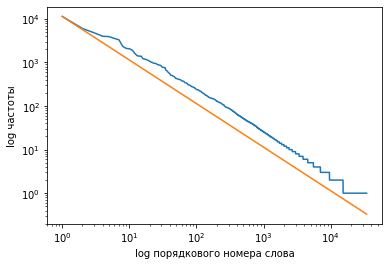

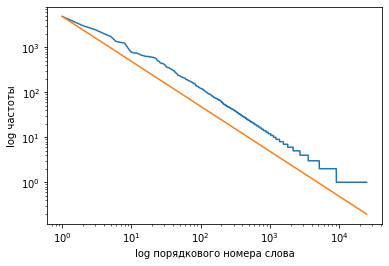

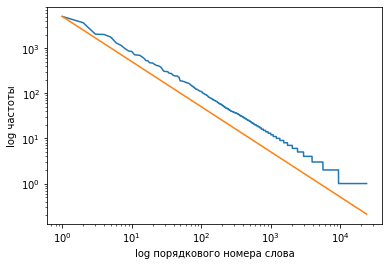

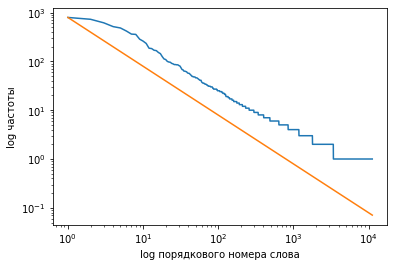

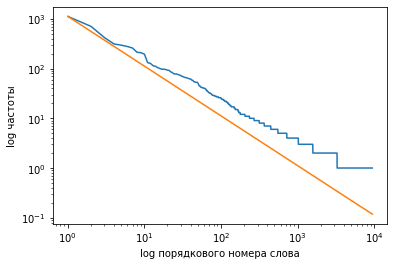

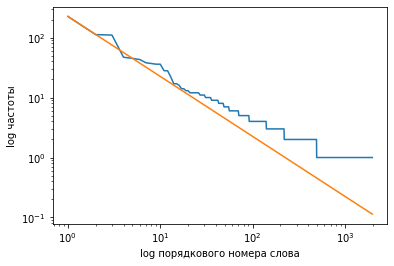

In [15]:
for e,i in Books:
    e.plot_with_Zipf(language = language.russian)

У более длинных текстов кривая становится плоской в некоторый момент. Видно, как с уменьшением количества слов кривая на начальном участке всё меньше похожа на прямую, но при этом начальный кусок приближается к предполагаемой кривой.
Только Лермонтов смог опуститься ниже Ципфофской кривой. Но вряд ли можно говорить, что это связано с его стилем.

hypothesis: [1.39200000e+03 6.96000000e+02 4.64000000e+02 ... 4.07864280e-02
 4.07852329e-02 4.07840380e-02]
hypothesis: [6.24000000e+02 3.12000000e+02 2.08000000e+02 ... 2.50934974e-02
 2.50924883e-02 2.50914794e-02]
hypothesis: [6.44000000e+02 3.22000000e+02 2.14666667e+02 ... 2.71203571e-02
 2.71192151e-02 2.71180731e-02]
hypothesis: [9.70000000e+01 4.85000000e+01 3.23333333e+01 ... 8.77589795e-03
 8.77510403e-03 8.77431027e-03]
hypothesis: [1.00000000e+02 5.00000000e+01 3.33333333e+01 ... 1.07215611e-02
 1.07204117e-02 1.07192625e-02]
hypothesis: [1.30000000e+01 6.50000000e+00 4.33333333e+00 ... 7.03844071e-03
 7.03463203e-03 7.03082747e-03]


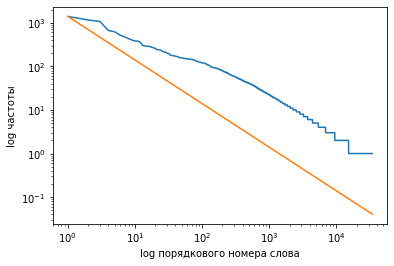

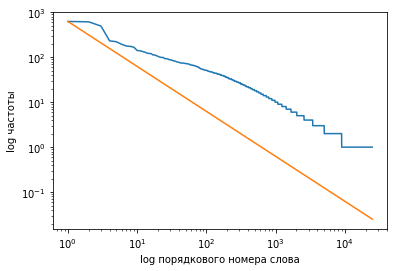

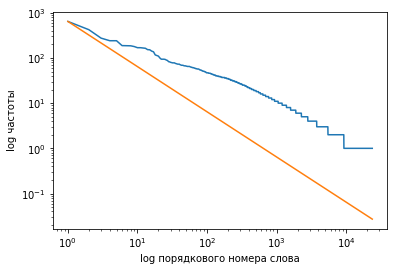

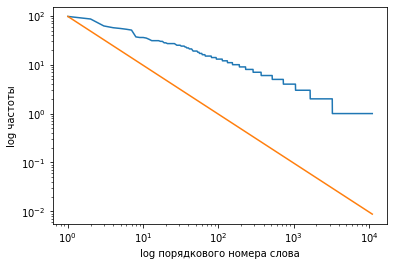

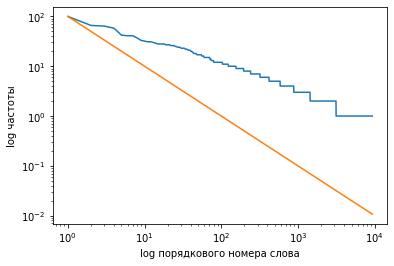

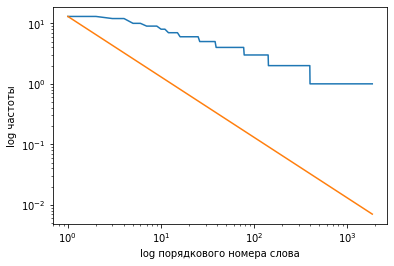

In [16]:
for e,i in Books:
    e.plot_with_Zipf(meaningful = True,language = language.russian)

Значащих слов гораздо меньше, но не поэтому результаты совсем не похожи на гипотезу. Значащих слов в Войне и мире всё ещё сильно больше, чем всех слов в остальных текстах. Это вполне логично, так как закон C/n не сохраняется при отрубании части слов, его логарифм как раз сдвигается на разность логарифмов n и n+k. Это может значить, что закон проявляется не чисто статистически и что он может быть связан со строением речи.

Разброс ошибок отклонения от закона падает с уменьшение числа слов, как и просто разброс слов. Но заметим, что для осмысленных слов, этот разброс стал значительно меньше, то есть структура, накладываемая на текст этой закономерностью, скорее влияет на значимые слова, чем на связки. Это ещё одна причина думать, что отклонения от Ципфофской кривой имеют некоторую связь со строением самого текста, а не только его числовыми характеристиками.

In [17]:
for e,i in Books:
    print(e.deviation_from_Zipf( meaningful = False, language = language.russian),
         e.deviation_from_Zipf( meaningful = True, language = language.russian))

26.24225480500266 11.85979682667748
16.985204738191744 5.984574445692272
14.531427371954036 5.573294060599833
9.10923772695252 2.2324242685062394
3.7281561421208314 2.0958367306677577
1.0463304186576694 0.8741748942756394


### Значимые слова

Выбрасываем союзы, частицы и всё в этом духе.

In [18]:
#my_meaningless_words.russian

In [19]:
for e,i in Books:
    print(f'Уникальных слов в {i}:', e.some_statistic( meaningful = True, language = language.russian)['number_of_words'], '\n',
         f'Слов в {i}:', e.some_statistic( meaningful = False, language = language.russian)['number_of_words'])

Уникальных слов в War_and_Peace_12: 146895 
 Слов в War_and_Peace_12: 240108
Уникальных слов в Dead_Souls_1: 70399 
 Слов в Dead_Souls_1: 117438
Уникальных слов в The_Master_and_Margarita: 71187 
 Слов в The_Master_and_Margarita: 112799
Уникальных слов в Who_is_Happy_in_Russia: 20752 
 Слов в Who_is_Happy_in_Russia: 30515
Уникальных слов в Eugene_Onegin: 17864 
 Слов в Eugene_Onegin: 26455
Уникальных слов в Mtsyri: 2576 
 Слов в Mtsyri: 3895


Так же заметим, что уникальных слов в Мастере и Маргарите, больше чем в Мёртвых душах. Возможно, в этом причина нарушения закономерности. У Пушкина такого нет, то есть в его случае выбросы объясняются более сложным набором причин.

В поэтических текстах вообще больше значимых, видимо это из-за того, что незначимые слова слишком короткие и часто не влезают в разбивку строк. Можно предполагать, что это общая закономерность, так как основное отличие поэтического текста от прозаического это дополнительная разбивка на строки.

In [20]:
for e,i in Books:
    print(e.percent_of_meaningful_words(language = language.russian))

61.17871957619071
59.945673461741514
63.10960203547904
68.00589873832541
67.52598752598753
66.13607188703466


Ещё заметим, что незначимые слова занимают более 30 процентов текста, то есть, наше вычисление процента значимых слов сейчас даст более интересные результаты.

In [21]:
for e,i in Books:
    print(e.percent_of_most_common_words(meaningful = True, language = language.russian),
         e.percent_of_most_common_words(meaningful = False, language = language.russian))

73.9902651553831 83.88766721641929
65.99667608914899 79.31078526541665
65.98395774509392 78.21345933917854
52.375674633770245 66.84909061117483
51.09158083296015 66.0971460971461
41.537267080745345 56.919127086007705


Проценты закономерно понизились, но интересно заметить, что, может быть в рамках погрешности, Гоголь с Булгаковым сблизились, а все остальные тексты отдалились друг от друга.

Можно посмотреть на графики количств слов встречающихся n раз.

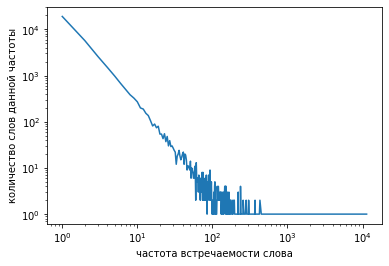

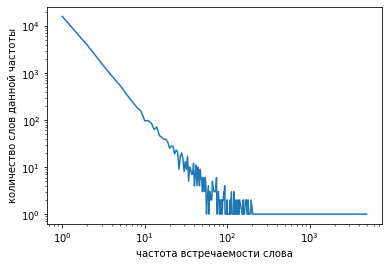

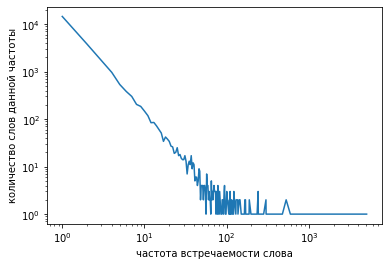

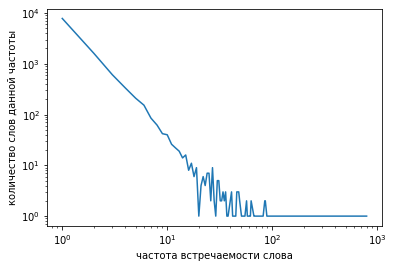

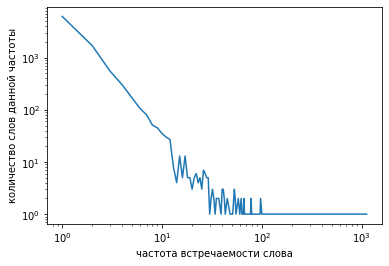

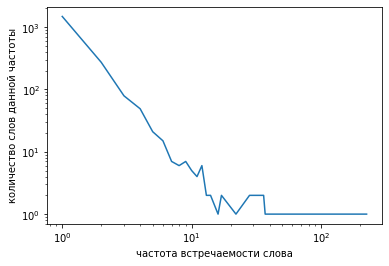

In [22]:
for e,i in Books:
    e.plot_the_number_of_phrases_by_occurrence(length = 1, language = language.russian, logarithmic = True)

Во всех маленьких текстах колебания происходят для слов встречающихся от 10 до 100 раз, в больших от 50 до 500. Видимо, в этих словах заключена основная смысловая нагрузка текста, это могут быть имена персонажей или куски значимых повторяющихся фраз.

## Выводы

Мы заметили несколько вещей, которые могут быть проверены на других текстах.

### Общие выводы



- Закон Ципфа связан не только со статистическими свойствами текста такими как длина, но и видит его структуру.
- Ничего сказать про различая отклонений от Ципфофской кривой стихотворных и прозаических текстов нельзя из-за маленького размера первых, но некоторые колебания кривых можно рассматривать в контексте особенностей конкретных авторов.
- Чтобы говорить о достоверности закона Ципфа необходимы тексты очень большого размера, самые точные результаты дала Война и мир, несмотря на то, что среднее значение и дисперсия у неё очень большие.
- Выкидывание из текста слов-связок имеет смысл, некоторые закономерности видны более явно.
- Случайная величина количество слов на данном месте в произвольном тексте скорее всего не имеет даже первого момента.
- Эмпирическое предположение, что 20 процентов слов занимают 80 процентов текста, не работает для маленьких текстов.




### Поэзия и проза


- Из-за маленького размера стихотворных текстов сложно говорить об их особенностях.
- Всё-таки можно увидеть, что на слова в стихотворных текстах накладывается больше ограничений.
- Количество значащих слов в стихотворных текстах больше, чем в прозаических. Утверждать это достоверно нельзя, так как нет чёткого определения значимого слова и отсутствие влияния размера, хоть и видно на примерах, не проверено в достаточной общности.
- Как в поэзи, так и в прозе авторы используют ключевые фразы, которые повторяются на протяжении всего текста.


### Про авторов

- У Булгакова мы видим меньшее разнообразие слов, чем у Гоголя, так же и у Некрасова с Пушкиным. Нельзя предположить, что это связано с поэтичностью самого текста, так как прозу Гоголя называют прозаической. Возможно, это связано с выстраиванием текста. Пушкин (несмотря на принцип болтовни в тексте) и Булгаков очень тщательно подбирают слова под контекст, что снижает разнообразие.
- Некрасов, Булгаков и Гоголь, повторяют некоторые длинные фразы, чего принципиально не делает Толстой.
- Лермонтов тоже не повторяет фразы, что может свидетельствовать о чисто рационалистическом, как и у Толстого, подходе к созднию текста, несмотря на экспрессивность его высказываний.
- Нарушений закономерностей, связанных с количеством слов, для Гоголя с Булгаковым могут объясняться большим количеством значимых слов у второго при меньшем количестве текста.
- Странности, возникшие в случае Пушкина, объяснить просто не получается.

## Дополнение

### Часто используемые слова

Теперь посмотрим на любимые слова писателей:

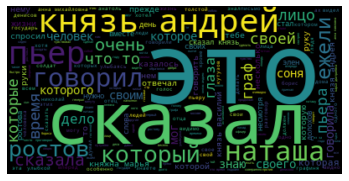

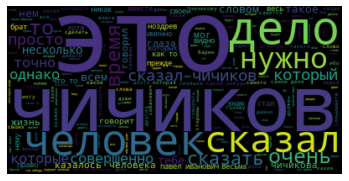

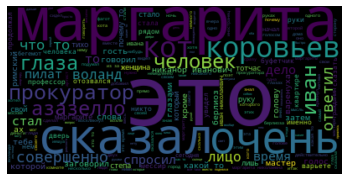

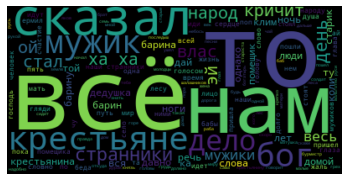

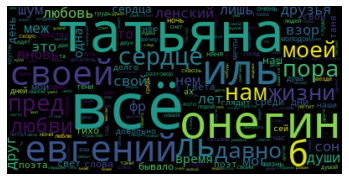

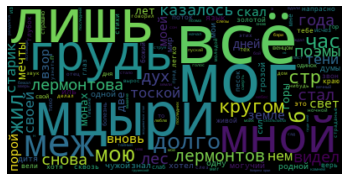

In [23]:
for e,i in Books:
    e.cloud(meaningful = True,language = language.russian )

Это и ожидали. 

Хотя 'я' - всё-таки не самое любимое слово Лермонтова.

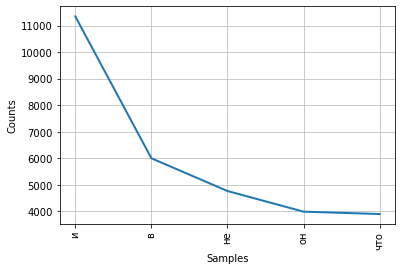

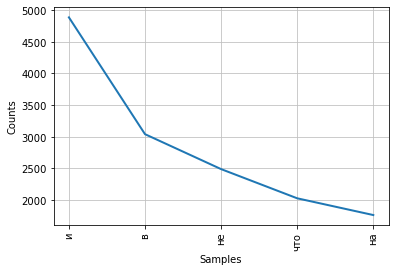

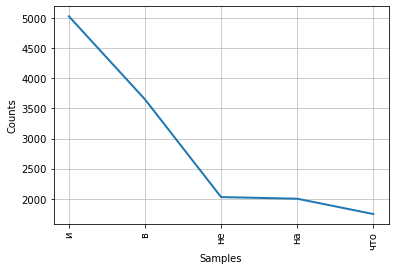

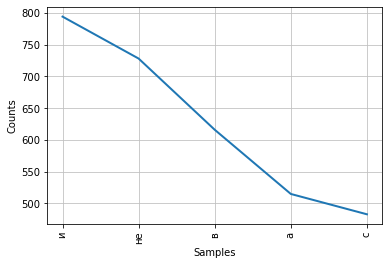

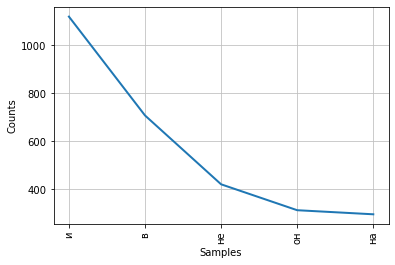

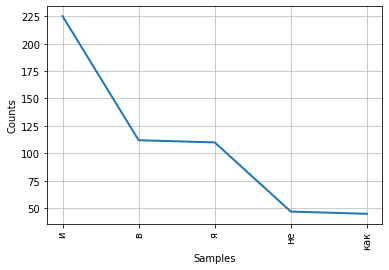

In [24]:
for e,i in Books:
    e.plot_word_statistic(5,language = language.russian)

У Пушкина 4 слово 'он', а у Некрасова нет ни 'он', ни 'я', видимо из-за большого количества персонажей.

Теперь посмотрим на самые частые фразы.

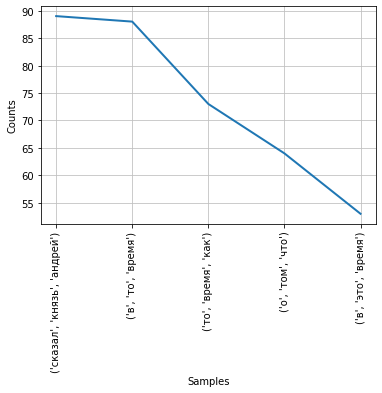

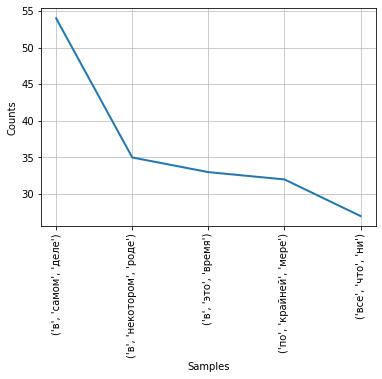

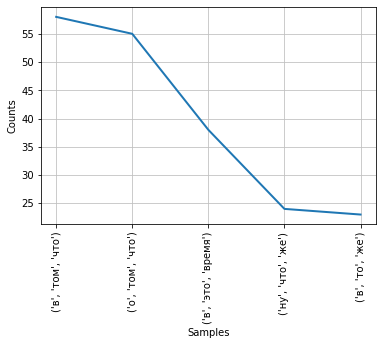

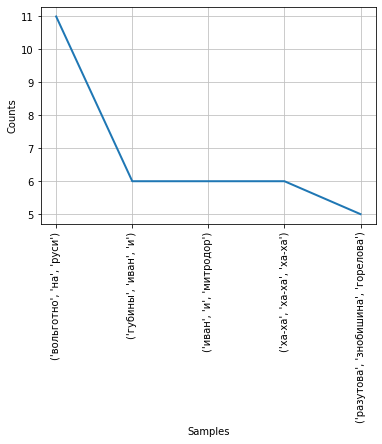

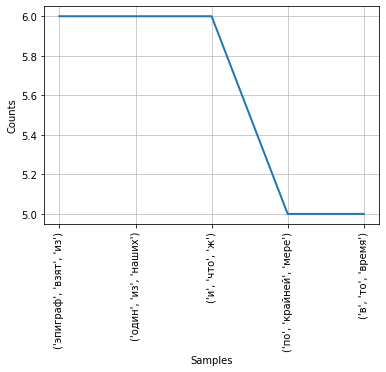

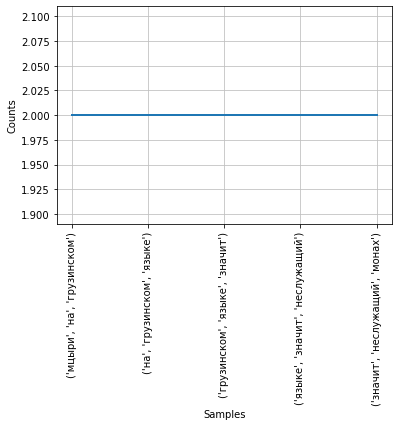

In [25]:
for e,i in Books:
    e.plot_phrases_statistic(number = 5,length = 3, language = language.russian)

(для длины 5) Тот самый белый плащ с кровавым подбоем.

Гоголь написал про приятную во всех отношениях даму аж 8 раз.


(для длины 4) Как же Пушкин любит обращаться к своим критикам.
![alt text](image.jpg '1')

(для длины 3) Всегда знал, что Толстой больше любит Андрея.

Лермонтов вообще почти не повторяет фразы, не считая некоторых замечаний про грузинский язык. Ну и Некрасов постоянно повторяет свою мантру: знобщина, горелова, неелова, неурожайка

#### Вывод

Надо не забывать подчищать текст, а то самая популярная фраза - название онлайн библиотеки.